In [35]:
import pandas as pd
import numpy as np
from scipy import stats, special

import seaborn as sns
from seaborn import pairplot, heatmap
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

from sklearn import model_selection, metrics, linear_model, tree, datasets, feature_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder

import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot


In [23]:
spotify_df = pd.read_csv('Spotify tracks dataset.csv') 
spotify_df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [7]:
spotify_df.shape

(114000, 21)

In [24]:
# Check for null values
print(spotify_df.isnull().sum())

# Drop rows with null values (if needed)
spotify_df.dropna(inplace=True)


Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


In [25]:
# Check for duplicate rows
print("Number of duplicate rows:", spotify_df.duplicated().sum())

# Remove duplicate rows
spotify_df.drop_duplicates(inplace=True)

# Display the cleaned dataset
spotify_df.shape

Number of duplicate rows: 0


(113999, 21)

In [16]:
numeric_cols = []
categorical_cols = []
for col in spotify_df.columns:
    if spotify_df[col].dtype == np.float64 or spotify_df[col].dtype == np.int64:
        numeric_cols.append(col)
    else:
        categorical_cols.append(col)

print('numeric columns:', numeric_cols)
print('Categorical columns:', categorical_cols)

numeric columns: ['Unnamed: 0', 'popularity', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
Categorical columns: ['track_id', 'artists', 'album_name', 'track_name', 'explicit', 'track_genre']


## Correlation plot

                  danceability    energy  loudness  speechiness  acousticness  \
danceability          1.000000  0.134325  0.259076     0.108625     -0.171531   
energy                0.134325  1.000000  0.761690     0.142508     -0.733908   
loudness              0.259076  0.761690  1.000000     0.060826     -0.589804   
speechiness           0.108625  0.142508  0.060826     1.000000     -0.002184   
acousticness         -0.171531 -0.733908 -0.589804    -0.002184      1.000000   
instrumentalness     -0.185608 -0.181880 -0.433478    -0.089617      0.104033   
liveness             -0.131620  0.184795  0.076897     0.205218     -0.020693   
valence               0.477347  0.258937  0.279851     0.036637     -0.107081   
popularity            0.035444  0.001053  0.050420    -0.044930     -0.025458   

                  instrumentalness  liveness   valence  popularity  
danceability             -0.185608 -0.131620  0.477347    0.035444  
energy                   -0.181880  0.184795  0.258

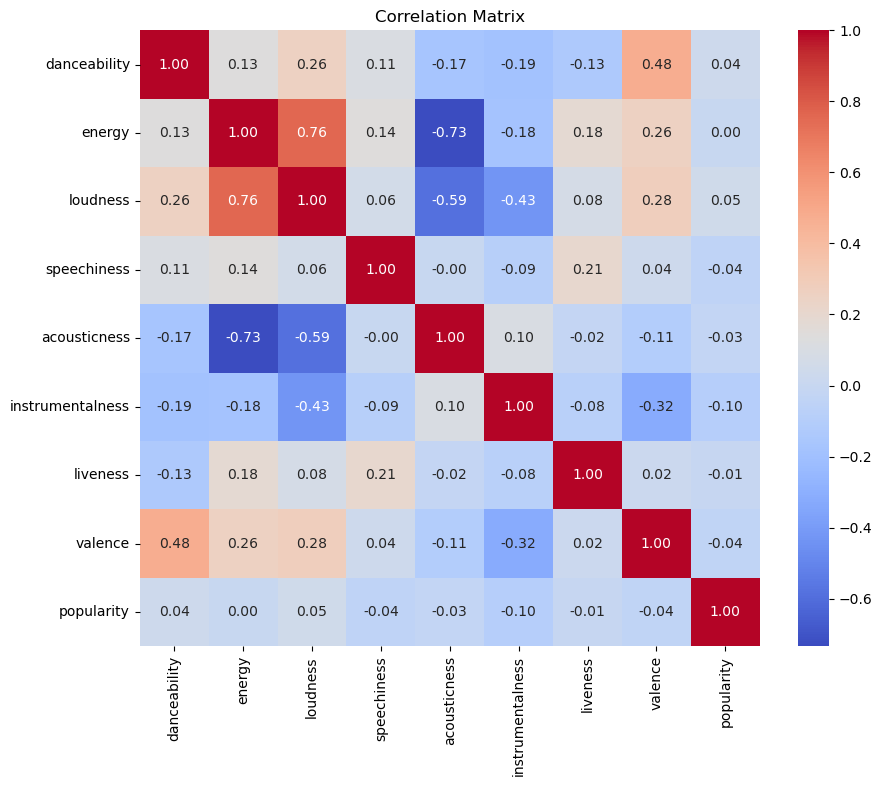

In [26]:
columns_of_interest = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', \
                        'instrumentalness', 'liveness', 'valence', 'popularity']

# Subset the dataframe to include only the specified columns
subset_data = spotify_df[columns_of_interest]

# Calculate the correlation matrix
correlation_matrix = subset_data.corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Linear regression

In [27]:
columns_of_interest = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
                       'instrumentalness', 'liveness', 'valence', 'popularity']

# Subset the dataframe to include only the specified columns
subset_data = spotify_df[columns_of_interest]

# Split data into independent variables (X) and the dependent variable (y)
X = subset_data.drop('popularity', axis=1)
y = subset_data['popularity']

# Add constant to the independent variables matrix for the intercept term
X = sm.add_constant(X)

# Fit OLS regression model
model = sm.OLS(y, X).fit()

# Print model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     322.7
Date:                Tue, 14 May 2024   Prob (F-statistic):               0.00
Time:                        09:57:47   Log-Likelihood:            -5.1443e+05
No. Observations:              113999   AIC:                         1.029e+06
Df Residuals:                  113990   BIC:                         1.029e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               37.8537      0.585  

In [29]:
# Create interaction terms
subset_data['danceability_energy_interaction'] = subset_data['danceability'] * subset_data['energy']
subset_data['loudness_energy_interaction'] = subset_data['loudness'] * subset_data['energy']
subset_data['valence_danceability_interaction'] = subset_data['valence'] * subset_data['danceability']
subset_data['speechiness_acousticness_interaction'] = subset_data['speechiness'] * subset_data['acousticness']
subset_data['instrumentalness_squared'] = subset_data['instrumentalness'] ** 2
subset_data['valence_squared'] = subset_data['valence'] ** 2
subset_data['danceability_squared'] = subset_data['danceability'] ** 2
subset_data['loudness_squared'] = subset_data['loudness'] ** 2

# Re-run the OLS regression with the new features
X = subset_data.drop('popularity', axis=1)
X = sm.add_constant(X)
model_with_interactions = sm.OLS(y, X).fit()
print(model_with_interactions.summary())


/var/folders/7x/2j_pjlnj2v32g7jvxdd86np80000gn/T/ipykernel_57002/2725500938.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7x/2j_pjlnj2v32g7jvxdd86np80000gn/T/ipykernel_57002/2725500938.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7x/2j_pjlnj2v32g7jvxdd86np80000gn/T/ipykernel_57002/2725500938.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     249.7
Date:                Tue, 14 May 2024   Prob (F-statistic):               0.00
Time:                        10:00:59   Log-Likelihood:            -5.1362e+05
No. Observations:              113999   AIC:                         1.027e+06
Df Residuals:                  113981   BIC:                         1.027e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


## Residuals

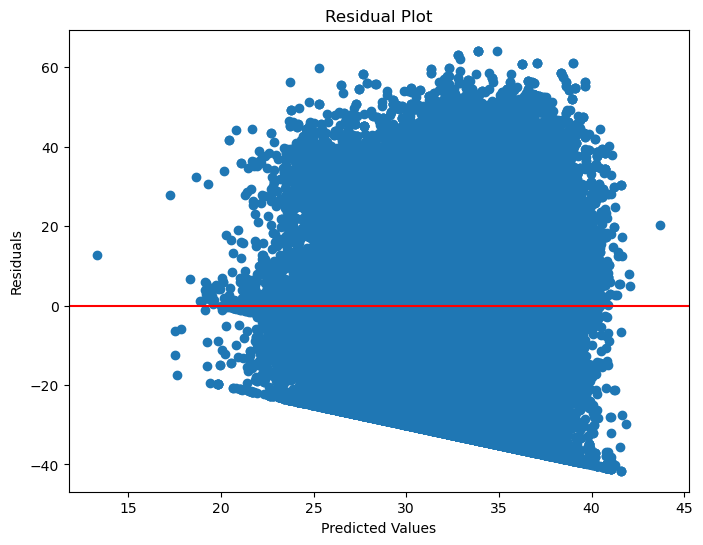

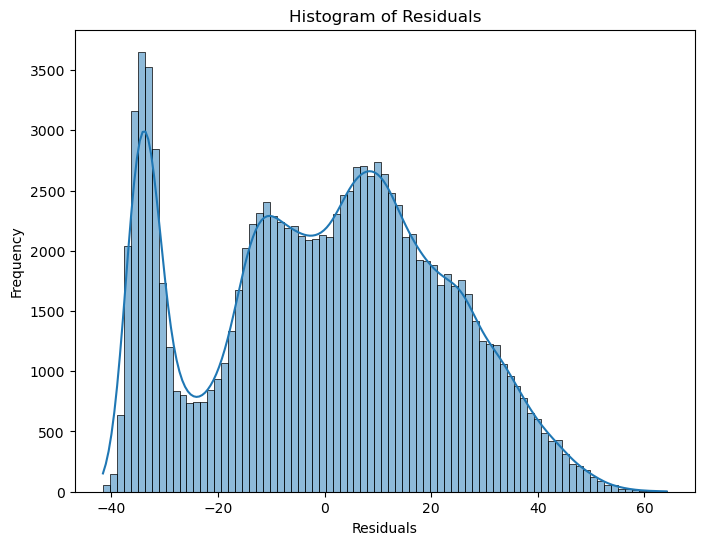

In [30]:
# Get residuals
residuals = model.resid

# Plot residuals vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(model.predict(), residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Plot histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


In [31]:
subset_data.columns

Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'popularity',
       'danceability_energy_interaction', 'loudness_energy_interaction',
       'valence_danceability_interaction',
       'speechiness_acousticness_interaction', 'energy_squared',
       'valence_squared', 'instrumentalness_squared', 'danceability_squared',
       'loudness_squared'],
      dtype='object')

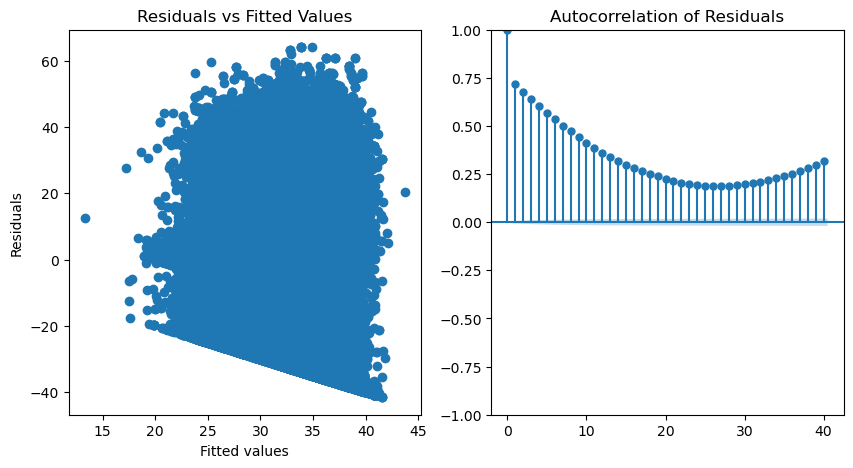

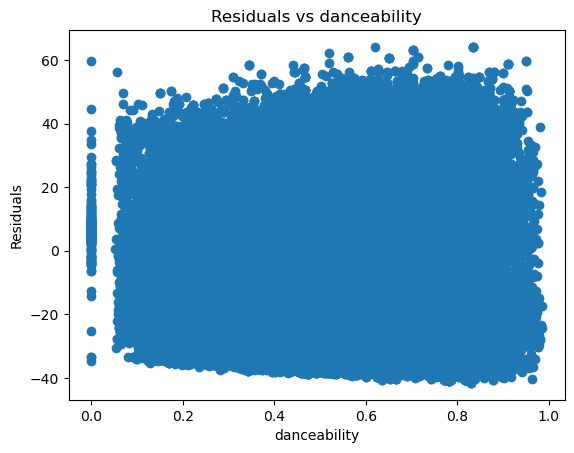

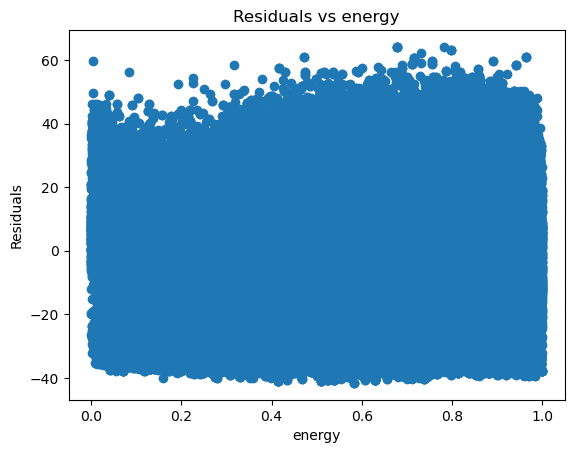

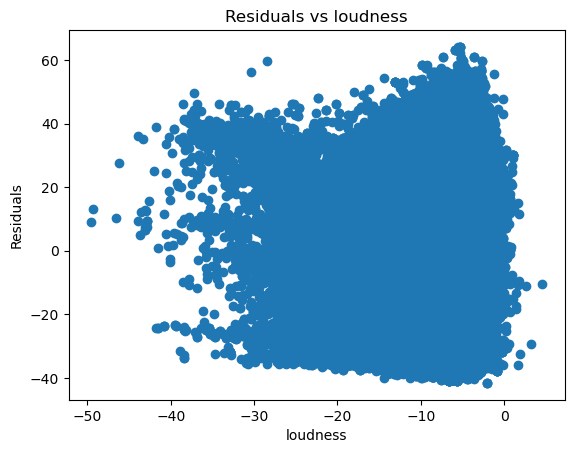

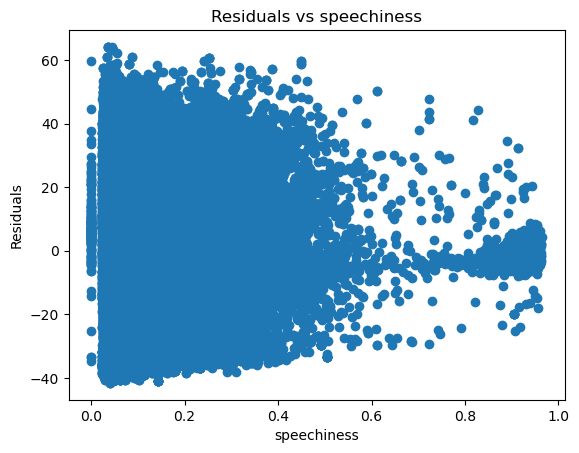

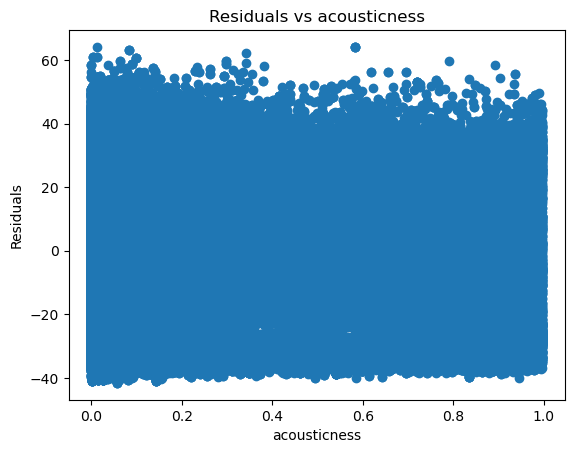

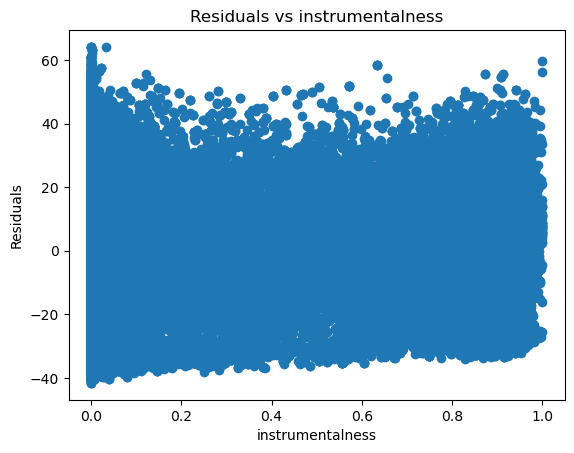

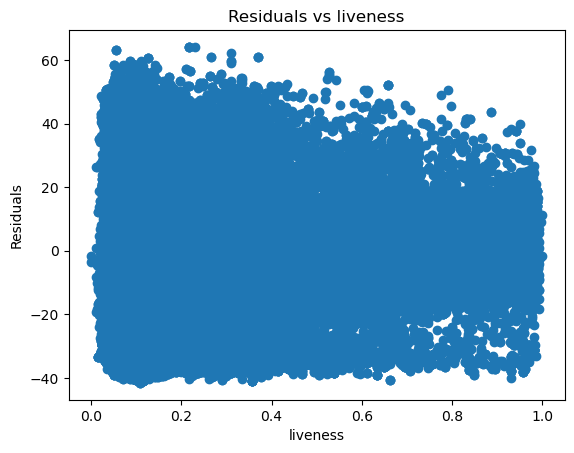

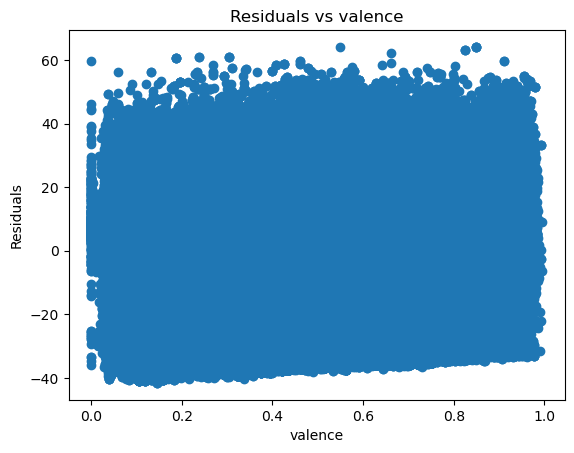

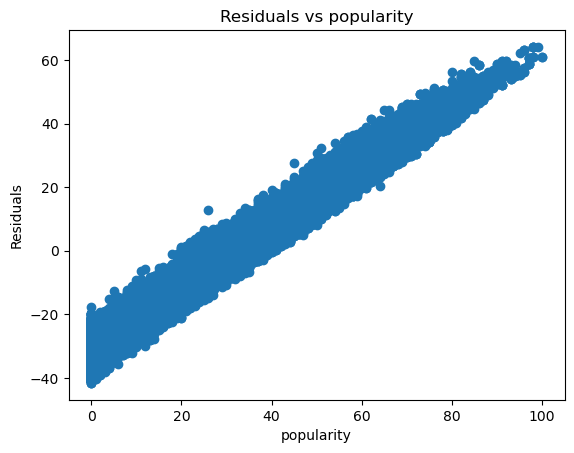

<Figure size 640x480 with 0 Axes>

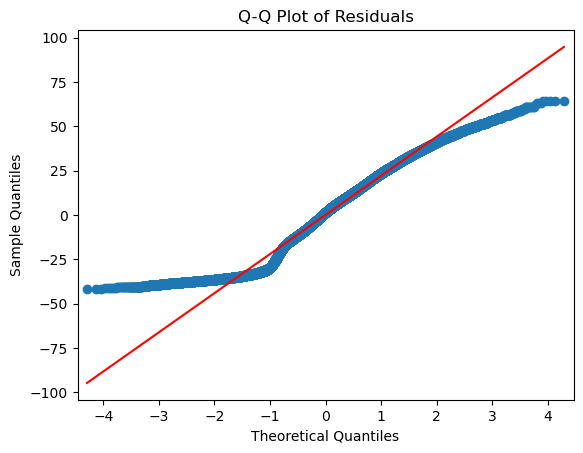

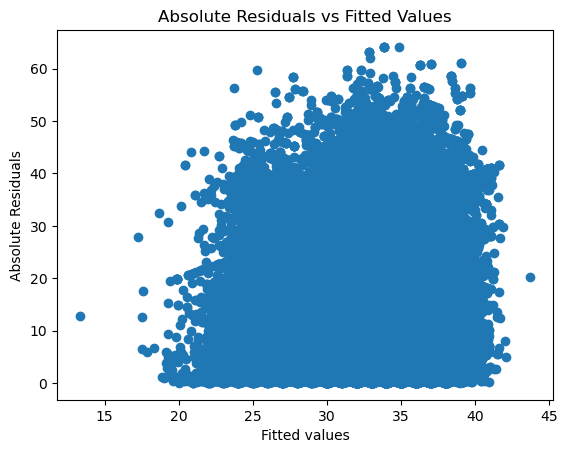

In [36]:
# 1. Mutually Independent Residuals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(model.fittedvalues, residuals)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')

plt.subplot(1, 2, 2)
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=plt.gca())
plt.title('Autocorrelation of Residuals')
plt.show()

# 2. Independence of Residuals and Covariates
for column in ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'popularity']:
    plt.figure()
    plt.scatter(spotify_df[column], residuals)
    plt.xlabel(column)
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs {column}')

# 3. Normality of Residuals
plt.figure()
qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

#Our graph is highly convex or right skewed. does 

# 4. Constant Variance of Residuals (Homoscedasticity)
plt.figure()
plt.scatter(model.fittedvalues, np.abs(residuals))
plt.xlabel('Fitted values')
plt.ylabel('Absolute Residuals')
plt.title('Absolute Residuals vs Fitted Values')
plt.show()

In [37]:
pure_popularity = spotify_df.sort_values('popularity', ascending=False).head(10)
pure_popularity[['track_name','track_genre', 'popularity']]

,track_name,track_genre,popularity
20001,Unholy (feat. Kim Petras),dance,100
81051,Unholy (feat. Kim Petras),pop,100
51664,"Quevedo: Bzrp Music Sessions, Vol. 52",hip-hop,99
89411,La Bachata,reggaeton,98
81210,I'm Good (Blue),pop,98
68303,La Bachata,latino,98
20008,I'm Good (Blue),dance,98
88410,La Bachata,reggae,98
30003,I'm Good (Blue),edm,98
67356,La Bachata,latin,98


In [28]:
#merging similar genres to the one general
#conert all value's lettercases to lower
# genre = (spotify_df["genre"].str.strip()).str.lower()

# def genre_splitter(genre):
#     result = genre.copy()
#     result = result.str.split(" ",1)
#     for i in range(len(result)):
#         if (len(result[i]) > 1):
#             result[i] = [result[i][1]]
#     return result.str.join('')


# def genre_splitter(genre):
#     result = genre.copy()
#     result = result.str.split(" ", 1)
#     for i in range(len(result)):
#         if (len(result[i]) > 1):
#             result[i] = [result[i][1]]
#     return result.str.join('')

# # Loop until the genre cannot be split any further
# new_genre = spotify_df['genre'].copy()
# while max(new_genre.str.split(" ").str.len()) > 1:
#     new_genre = genre_splitter(new_genre)
    
# print('New Total of Genres from 146 to -->', len(new_genre.unique()))

def genre_splitter(genre):
    return genre.str.replace(r'^\S+\s', '', regex=True)

# Loop until the genre cannot be split any further
new_genre = spotify_df['genre'].copy()
while max(new_genre.str.count(' ')) > 0:
    new_genre = genre_splitter(new_genre)
    
spotify_df['genre'] = new_genre
spotify_df.head()

,title,artist,genre,year,beats_per_minute,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,popularity
0,Sunrise,Norah Jones,standards,2004,157,30,53,-14,11,68,201,94,3,71
1,Black Night,Deep Purple,rock,2000,135,79,50,-11,17,81,207,17,7,39
2,Clint Eastwood,Gorillaz,hop,2001,168,69,66,-9,7,52,341,2,17,69
3,The Pretender,Foo Fighters,metal,2007,173,96,43,-4,3,37,269,0,4,76
4,Waitin' On A Sunny Day,Bruce Springsteen,rock,2002,106,82,58,-5,10,87,256,1,3,59


## Logistic Regression

In [39]:
spotify_df['popularity_b'] = pd.qcut(spotify_df['popularity'], q=2, labels=[0, 1]) 
#spotify_df[['popularity_b']].head()
spotify_df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_b
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,1
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,1
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,1
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,1
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,1


In [40]:
target_v = spotify_df['popularity_b'].value_counts(normalize=True).round(3)
target_v

popularity_b
0    0.513
1    0.487
Name: proportion, dtype: float64

<Axes: xlabel='popularity_b', ylabel='proportion'>

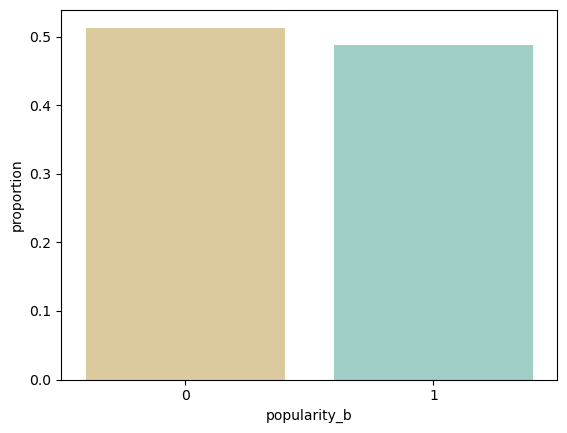

In [41]:
sns.barplot(x=target_v.index, y=target_v, palette="BrBG")

In [43]:

columns_of_interest = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
                       'instrumentalness', 'liveness', 'valence', 'popularity_b']

# Subset the dataframe to include only the specified columns
subset_data2 = spotify_df[columns_of_interest]

# Split data into independent variables (X) and the dependent variable (y)
X = subset_data2.drop('popularity_b',  axis=1)
y = subset_data2['popularity_b']

# Using statsmodels
X = sm.add_constant(X)
logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.673773
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           popularity_b   No. Observations:               113999
Model:                          Logit   Df Residuals:                   113990
Method:                           MLE   Df Model:                            8
Date:                Tue, 14 May 2024   Pseudo R-squ.:                 0.02750
Time:                        10:25:58   Log-Likelihood:                -76809.
converged:                       True   LL-Null:                       -78981.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4680      0.055      8.558      0.000       0.361       0.575
danceabilit

In [44]:
# Create interaction terms
subset_data2['danceability_energy_interaction'] = subset_data2['danceability'] * subset_data2['energy']
subset_data2['loudness_energy_interaction'] = subset_data2['loudness'] * subset_data2['energy']
subset_data2['valence_danceability_interaction'] = subset_data2['valence'] * subset_data2['danceability']
subset_data2['speechiness_acousticness_interaction'] = subset_data2['speechiness'] * subset_data2['acousticness']
subset_data2['instrumentalness_squared'] = subset_data2['instrumentalness'] ** 2
subset_data2['valence_squared'] = subset_data2['valence'] ** 2
subset_data2['danceability_squared'] = subset_data2['danceability'] ** 2
subset_data2['loudness_squared'] = subset_data2['loudness'] ** 2

# Re-run the OLS regression with the new features
X = subset_data.drop('popularity_b', axis=1)
X = sm.add_constant(X)

logit_model_inter = sm.Logit(y, X)
result = logit_model_inter.fit()
print(result.summary())

/var/folders/7x/2j_pjlnj2v32g7jvxdd86np80000gn/T/ipykernel_57002/84683971.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7x/2j_pjlnj2v32g7jvxdd86np80000gn/T/ipykernel_57002/84683971.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7x/2j_pjlnj2v32g7jvxdd86np80000gn/T/ipykernel_57002/84683971.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Optimization terminated successfully.
         Current function value: 0.673773
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           popularity_b   No. Observations:               113999
Model:                          Logit   Df Residuals:                   113990
Method:                           MLE   Df Model:                            8
Date:                Tue, 14 May 2024   Pseudo R-squ.:                 0.02750
Time:                        10:27:24   Log-Likelihood:                -76809.
converged:                       True   LL-Null:                       -78981.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4680      0.055      8.558      0.000       0.361       0.575
danceabilit